In [45]:
from datasets import load_from_disk
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
train = load_from_disk('parsed_yelp_reviews//gianni_train.hf')
test = load_from_disk('parsed_yelp_reviews//gianni_test.hf')

In [21]:
# Il dataset che vi ho mandato tra i token contiene anche tutta la punteggiatura quindi per fare tutti i conteggi delle parole l'ho tolta
def remove_punctuation(doc):
    punc = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '
    doc['tokens_no_punc'] = [tok for tok in doc['tokens'] if tok not in punc]
    return doc

test = test.map(remove_punctuation, num_proc= 4)
train = train.map(remove_punctuation, num_proc = 4)

Map (num_proc=4): 100%|██████████| 650000/650000 [01:50<00:00, 5870.66 examples/s]


In [22]:
# tolto la vecchia colonna dei tokens
train = train.remove_columns('tokens')
test = test.remove_columns('tokens')

In [24]:
# calcolo la lunghezza dei documenti e il numero di frasi contenuto in ogni documento
def calculate_lengths(doc):
    doc['length'] = len(doc['tokens_no_punc'])
    doc['n_sentences'] = len(doc['sentences'])
    return doc
test = test.map(calculate_lengths, num_proc= 4)
train = train.map(calculate_lengths, num_proc = 4)

Map (num_proc=4): 100%|██████████| 650000/650000 [01:45<00:00, 6176.87 examples/s]


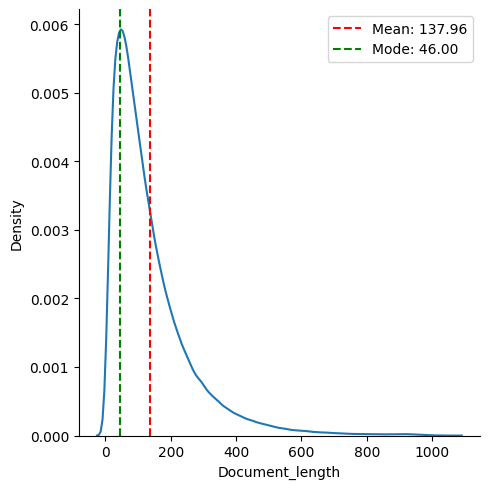

In [60]:
# Distribuzione delle lunghezze
total_lengths = np.concatenate((np.array(train['length']),np.array(test['length']) ))
sns.displot(data=pd.DataFrame(total_lengths, columns= ['Document_length']), x='Document_length', kind="kde")
mean_length = np.mean(np.array(total_lengths))
median_length = np.median(np.array(total_lengths))
mode_length = np.argmax(np.bincount(total_lengths))
plt.axvline(mean_length, color='r', linestyle='--', label=f'Mean: {mean_length:.2f}')
plt.axvline(mode_length, color='g', linestyle='--', label=f'Mode: {mode_length:.2f}')
plt.legend()

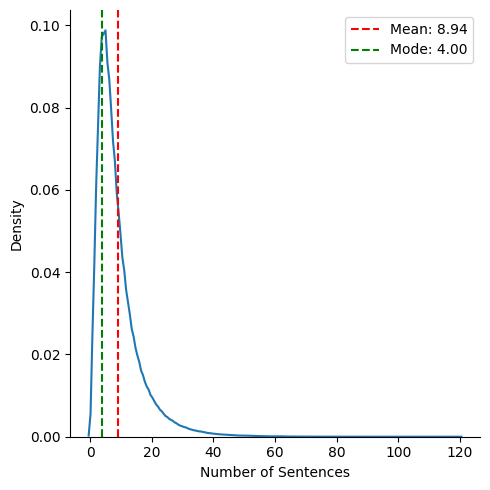

In [61]:
# Distribuzione del numero di frasi
sentence_length = np.concatenate((np.array(train['n_sentences']),np.array(test['n_sentences']) ))
sns.displot(data=pd.DataFrame(sentence_length, columns= ['Number of Sentences']), x='Number of Sentences', kind="kde")
mean_length = np.mean(np.array(sentence_length))
median_length = np.median(np.array(sentence_length))
mode_length = np.argmax(np.bincount(sentence_length))
plt.axvline(mean_length, color='r', linestyle='--', label=f'Mean: {mean_length:.2f}')
plt.axvline(mode_length, color='g', linestyle='--', label=f'Mode: {mode_length:.2f}')
plt.legend()

In [78]:
# Questa fradicia ha fatto una recensione da 1065 parole 
print(train[int(np.argmax(total_lengths))]['length'])
print(train[int(np.argmax(total_lengths))]['label'])


1065
3


In [75]:
# Senza i caratteri di newline era impossibile leggerla, ho chiesto a chatgpt di aggiungere lui dei caratteri di newline per leggerla
long_review ='We stayed here the weekend of 4/19/13 to 4/21/13 \nI booked this hotel on hotels.com. We came her for my sisters 21st birthday and me and my husband wanted to find something cheap and roomy and we noticed this place had a kitchen and washer/dryer so so i booked it right then and there, i noticed it wasn\'t on the strip but that\'s fine because it had a free shuttle service and that was great we planed on using it but i will talk more about that later. \n\nThe service:So we walking into the lobby to check in and it was packed people looked confused and so did the workers they just looked over whelmed like they had never seen that many people in there hotel before (i guess people were there for a time share presentation) so we make or way up the the registration desk and a nice young man welcomes us and says if he can help and i say yes and we check in he was really nice i don\'t remember his name but (i believe it was delmar) i could be wrong not sure.Anyways we have to go to another desk to get a parking pass (which is free) and the lady asked if we were part of the time share thing we said no and she asked if we wanted to go and see if we were interested and we would get a gift card of 100$ so i said sure why not i always wanted to see how those worked anyway so she signs us up for the next morning. \n\nThe Room: We finally make our way up to the room and you know how they always make the picture online look all fancy and when you get there it isn\'t well i kid you not when we got to our room it looked exactly like the picture but better the kitchen was great it came complete with everything you would need and the washer/dryer was really easy to use if your husband can use it you know its easy haha there were two showers and the master shower had two shower heads which me and my husband though where cool especially if you want to save water ;) the room was great the bed was comfortable and they had a lot of towels we didn\'t even has to call for more. \n\nThe pool: We didn\'t get a chance to go in were we busy with my sister birthday a lot of the time and we really wanted to go in but time wasn\'t on our side but it looked nice we went to go check it out there is a bar in there but for some reason it isn\'t open like there was no liquor or cups like it was new which i though was weird but whatever. \n\nThe shuttle: Okay so the shuttle where do i start its a good idea but it only comes every 1 hour and it doesn\'t bring you back which is weird because there right next to the MGM grand so they could or should make it were they drop you off there since the monorail is there anyways if you wanted to get a round and also they stop it around 8 which is lame because no one party\'s that early unless you plan on getting drunk before 11 and going home haha and it would be great not having to worry about drinking and driving and taxi here are so expensive its crazy so i wished it could of did that but i know your probably thinking now your asking for to much lol but still that just my 2 cents. \n\nThe time share: We woke up early around 9am since it was at 10am the lady said to come 10 mins early so we did so we can check in there,so we tell them our name and they cant find us they go and look around ask other employees get the main managers and then finally say they have to sign us up again so we get told to go out again and sign up were we were last time, so we go and this nice lady helps us (this time i really don\'t remember here name), so we sign up again and she apologize for the inconvenience and says instead of 100$ we will get 125$ so i am like okay that\'s really nice of her, so we go to the time share thing and this guy name ron is talking about all the great places he has been and starts saying how it our fault that "we" don\'t ever go on vacation and blah blah talking about all the money he has and all the places he has been (you know if you have been to one) they say there not gonna presser you but they did when we get out but we cant afford it and honestly it sounded great but we have small kids and it just wont work now,so what did i learn about this: well you know that line time is money well for poor people or not so financially people ,money is time because if you have the money then you would have the time, you cant go on vacation with out money first! \n\nThe check out: so we woke up at 9 and our check out time is at 10 and we wanted to eat and go swimming before we left, so i called down stairs and ask if we could stay longer and they said we can stay till 11 and after that its 20$ an hour so me and my husband go out to eat we get home around 10 and decided we need to leave because we really missed our kids and our home but honestly i wished we could have stayed longer and next time we are gonna bring the kids because the whole time we were there we kept talking about how the kids would enjoy this and everything vegas has to offer for the kids, i cant write anymore so i will leave it at this We had a great time and will be coming back'

print(long_review)


We stayed here the weekend of 4/19/13 to 4/21/13 
I booked this hotel on hotels.com. We came her for my sisters 21st birthday and me and my husband wanted to find something cheap and roomy and we noticed this place had a kitchen and washer/dryer so so i booked it right then and there, i noticed it wasn't on the strip but that's fine because it had a free shuttle service and that was great we planed on using it but i will talk more about that later. 

The service:So we walking into the lobby to check in and it was packed people looked confused and so did the workers they just looked over whelmed like they had never seen that many people in there hotel before (i guess people were there for a time share presentation) so we make or way up the the registration desk and a nice young man welcomes us and says if he can help and i say yes and we check in he was really nice i don't remember his name but (i believe it was delmar) i could be wrong not sure.Anyways we have to go to another desk to 

In [81]:
# Calcolo le parole più popolari (non sono riuscito a usare la colonna tokens perchè era davvero enorme e ho dovuto usare countvectorizer, ma ci lavorerò)
vectorizer = CountVectorizer(stop_words='english',min_df=5,max_df=.5)
vector_documents_train = vectorizer.fit_transform(train['text'])

In [82]:
vocab = vectorizer.get_feature_names_out()
occurencies = np.asarray(vector_documents_train.astype(bool).sum(axis=0)).flatten()
vocab_occurencies = {vocab[i]:occurencies[i] for i in range(len(vocab))}
sorted_vocab = dict(sorted(vocab_occurencies.items(), key=lambda item: item[1], reverse = True))

In [86]:
sorted_vocab

{'place': 250505,
 'good': 250117,
 'food': 241954,
 'like': 207118,
 'just': 205447,
 'service': 184942,
 'great': 177019,
 'time': 174050,
 'really': 147578,
 'don': 122863,
 'ni': 116539,
 'got': 113910,
 'nthe': 108295,
 'nice': 107339,
 've': 105751,
 'didn': 100592,
 'went': 96907,
 'did': 94177,
 'people': 92868,
 'little': 92240,
 'ordered': 91911,
 'better': 91576,
 'came': 89646,
 'pretty': 87810,
 'best': 87691,
 'try': 84452,
 'restaurant': 84203,
 'order': 83719,
 'way': 82992,
 'know': 82567,
 'going': 82440,
 'come': 80656,
 'make': 78136,
 'think': 78019,
 'staff': 77405,
 'love': 74611,
 'bad': 72930,
 'say': 72740,
 'want': 72455,
 'friendly': 71714,
 'said': 71556,
 'night': 71346,
 'menu': 70843,
 'experience': 70514,
 'right': 70295,
 'vegas': 66961,
 'day': 65121,
 'eat': 64039,
 'wasn': 63898,
 'sure': 63744,
 'bar': 63269,
 'definitely': 62566,
 'wait': 62115,
 'chicken': 60888,
 'took': 60418,
 'minutes': 59467,
 'times': 59183,
 'new': 58298,
 'thing': 57321,


In [98]:
# Per ogni tipo di recensione(1,2,3,4,5 stelle) calcolo in media quante parole hanno
total_labels = np.concatenate((np.array(train['label']), np.array(test['label']))) + 1
label_length = {i+1:[] for i in range(5)}
for len,lab in zip(total_lengths, total_labels):
    label_length[lab].append(len)
label_length = {lab: np.mean(np.array(len)) for lab, len in label_length.items()}

In [99]:
# In media chi si lamenta scrive recensioni più lunghe
label_length

{1: 155.4279,
 2: 156.6563642857143,
 3: 143.03605,
 4: 127.02003571428571,
 5: 107.67428571428572}

In [101]:
# Il dataset è bilanciato
un,count = np.unique(total_labels,return_counts= True)
print(un, count)

[1 2 3 4 5] [140000 140000 140000 140000 140000]
